# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Dynamic Connection

<img src="Figures/system_layout_alternative_2.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="ticks")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000), 
             ('New-Panamax (12,500 TEU)', 12500), 
             ('ULCS (21,000 TEU)', 21000)],
    value=12500, 
    description='Capacity:')

barge = widgets.Dropdown(
    options=[('Small (200 TEU)', 200), 
             ('Medium (250 TEU)', 250), 
             ('Large (300 TEU)', 300)],
    value=250, 
    description='Barge capacity:')

life_cycle = widgets.IntSlider(
    value=10, min=5, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('Input Values')
display(annual_demand, offshore_onshore_distance, container_ship, barge, life_cycle)

Input Values


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='Capacity:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,50…

Dropdown(description='Barge capacity:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250),…

IntSlider(value=10, description='Life cycle:', max=30, min=5, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

In [4]:
# %store -r total_ocean_transport

# demand = []

# for year in years:
#     if year < 2025:
#         demand.append(total_ocean_transport)
#     elif year < 2030:
#         demand.append(total_ocean_transport * 1.5)
#     else:
#         demand.append(total_ocean_transport * 2.0)

# plt.plot(years, demand, 'o')
# plt.ylabel('Demand [TEU]')
# plt.ylim(0,)

In [5]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand}

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container.scenario_data)

# combine
demand = [container]

{'name': 'Laden', 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0}


## 0.2 Generate vessels

In [6]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [7]:
Terminal = container_system.System(startyear = startyear,
                                   lifecycle = lifecycle,
                                   stack_equipment='rs',
                                   laden_stack='rs',
                                   crane_type_defaults=container_defaults.sts_crane_data,
                                   system_layout='offshore',
                                   allowable_berth_occupancy = 0.50,
                                   transhipment_ratio = 0.0,
                                   elements = demand + vessels,
                                   laden_perc = 0.80, 
                                   reefer_perc = 0.10, 
                                   empty_perc = 0.05, 
                                   oog_perc = 0.05,
                                   operational_hours = 8640,     # 360 days 
                                   debug=True)                   # provide intermediate outputs via print statements

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, revenues)
    7. calculate PV's and aggregate to NPV

In [8]:
Terminal.simulate()


Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year       Capex  Maintenance  Insurance
0  2020  24334677.0          0.0        0.0
1  2021  16223118.0          0.0        0.

c:\checkouts\opentisim\opentisim\container_system.py:1660: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system.py:2147: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system.py:1708: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year      Capex  Maintenance
0  2020        0.0          0.0
1  2021  1312800.0          0.0
2  2022        0.0     116280.0
3  2023        0.0     116280.0
4  2024        0.0     116280.0
  *** add Laden Stack to elements
df    Year      Capex  Maintenance
0  2020        0.0          0.0
1  2021  1312800.0          0.0
2  2022        0.0     116280.0
3  2023        0.0     116280.0
4  2024        0.0     116280.0
  *** add Laden Stack to elements
df    Year      Capex  Maintenance
0  2020        0.0          0.0
1  2021  1312800.0          0.0
2  2022        0.0     116280.0
3  2023        0.0     116280.0
4  2024        0.0     116280.0
  *** add Laden Stack to elements
df    Year      Capex  Maintenance
0  2020        0.0          0.0
1  2021  1312800.0          0.0
2  2022        0.0     116280.0
3  2023        0.0     116280.0
4  2024        0.0     116280.0
  *** add Laden Stack to elements
df    Year      Capex  Maintenance
0  2020        0.0          0.0
1  2021  1312800.0 

df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  107187.0          0.0       0.0
2  2022       0.0        600.0  250000.0
3  2023       0.0        600.0  250000.0
4  2024       0.0        600.0  250000.0
  *** add Gate to elements
df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  107187.0          0.0       0.0
2  2022       0.0        600.0  250000.0
3  2023       0.0        600.0  250000.0
4  2024       0.0        600.0  250000.0
  *** add Gate to elements
df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  107187.0          0.0       0.0
2  2022       0.0        600.0  250000.0
3  2023       0.0        600.0  250000.0
4  2024       0.0        600.0  250000.0
  *** add Gate to elements
df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  107187.0          0.0       0.0
2  2022       0.0        600.0  250000.0
3  20

4  2024       0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year     Capex  Maintenance         Labour
0  2020       0.0          0.0       0.000000
1  2021  505000.0          0.0       0.000000
2  2022       0.0      10000.0  166153.846154
3  2023       0.0      10000.0  166153.846154
4  2024       0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year     Capex  Maintenance         Labour
0  2020       0.0          0.0       0.000000
1  2021  505000.0          0.0       0.000000
2  2022       0.0      10000.0  166153.846154
3  2023       0.0      10000.0  166153.846154
4  2024       0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year     Capex  Maintenance         Labour
0  2020       0.0          0.0       0.000000
1  2021  505000.0          0.0       0.000000
2  2022       0.0      10000.0  166153.846154
3  2023       0.0      10000.0  166153.846154
4  2024       0.0      10000.0  166153.846154
  *** add Tractor to elemen

df    Year       Capex  Maintenance
0  2020         0.0          0.0
1  2021  33319000.0          0.0
2  2022         0.0     499785.0
3  2023         0.0     499785.0
4  2024         0.0     499785.0

Below, the various investment decisions are evaluated for the year 2022.

Simulate year: 2022
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 9 STS_crane is online; 9 total planned

  Start analysis:
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
     Berth occupancy planned (@ start of year): 0.478
     Berth occupancy online  (@ start of year): 0.478
     Crane occupancy planned (@ start of year): 0.33
     Crane occupancy 

df    Year    Capex  Maintenance         Labour
0  2020      0.0          0.0       0.000000
1  2021  86000.0          0.0       0.000000
2  2022      0.0       8500.0  166153.846154
3  2023      0.0       8500.0  166153.846154
4  2024      0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year    Capex  Maintenance         Labour
0  2020      0.0          0.0       0.000000
1  2021  86000.0          0.0       0.000000
2  2022      0.0       8500.0  166153.846154
3  2023      0.0       8500.0  166153.846154
4  2024      0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year    Capex  Maintenance         Labour
0  2020      0.0          0.0       0.000000
1  2021  86000.0          0.0       0.000000
2  2022      0.0       8500.0  166153.846154
3  2023      0.0       8500.0  166153.846154
4  2024      0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year    Capex  Maintenance         Labour
0  2020      0.0          0.0       0.00000

df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  505000.0          0.0       0.0
2  2022       0.0      50000.0  250000.0
3  2023       0.0      50000.0  250000.0
4  2024       0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  505000.0          0.0       0.0
2  2022       0.0      50000.0  250000.0
3  2023       0.0      50000.0  250000.0
4  2024       0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  505000.0          0.0       0.0
2  2022       0.0      50000.0  250000.0
3  2023       0.0      50000.0  250000.0
4  2024       0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  505000.0          0.0       0.0
2  2022      

df    Year     Capex  Maintenance    Labour
0  2020       0.0          0.0       0.0
1  2021  505000.0          0.0       0.0
2  2022       0.0      50000.0  250000.0
3  2023       0.0      50000.0  250000.0
4  2024       0.0      50000.0  250000.0
     Gate capacity planned     (@ start of year): 600
     Gate capacity online      (@ start of year): 600
     Gate service rate planned (@ start of year): 0.901
     Gate lane minutes         (@ start of year): 541

     Empty Handlers online (@ start of year): 45


Below, the various investment decisions are evaluated for the year 2023.

Simulate year: 2023
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 9 STS_crane is online; 9 total plann

c:\checkouts\opentisim\opentisim\container_system.py:567: FutureWarning:

`item` has been deprecated and will be removed in a future version



   Year         Capex  Capital Dredging   Maintenance     Insurance  \
0  2020  7.722579e+07      5.000000e+07  0.000000e+00  0.000000e+00   
1  2021  2.644186e+08      4.402624e+07  0.000000e+00  0.000000e+00   
2  2022  0.000000e+00      0.000000e+00  1.706716e+07  2.325948e+06   
3  2023  0.000000e+00      0.000000e+00  1.502806e+07  2.048055e+06   
4  2024  0.000000e+00      0.000000e+00  1.323258e+07  1.803363e+06   
5  2025  0.000000e+00      0.000000e+00  1.165161e+07  1.587906e+06   
6  2026  0.000000e+00      0.000000e+00  1.025953e+07  1.398191e+06   
7  2027  0.000000e+00      0.000000e+00  9.033775e+06  1.231142e+06   
8  2028  0.000000e+00      0.000000e+00  7.954464e+06  1.084051e+06   
9  2029  0.000000e+00      0.000000e+00  7.004103e+06  9.545338e+05   

         Energy        Labour          Fuel  Demurrage  Barge Transport  \
0  0.000000e+00  0.000000e+00  0.000000e+00        0.0              0.0   
1  0.000000e+00  0.000000e+00  0.000000e+00        0.0              

## 3. Report all elements

In [9]:
if True: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table. 
        # object.__dict__ A dictionary or other mapping object used to store an object's (writable) attributes.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1000000
6  2026  1000000
7  2027  1000000
8  2028  1000000
9  2029  1000000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '5d1ee3e6-152a-11ea-9d84-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'name': 'Fully_Cellular_1', 'id': '5d2069de-152a-11ea-9d27-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, '

{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'residual': [], 'fuel': [], 'capex': 86000, 'capital_dredging': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2022, 'name': 'Tractor-trailer', 'id': '5db92bf4-152a-11ea-b08e-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year    Capex  Maintenance         Labour          Fuel
0  2020      0.0          0.0       0.000000      0.000000
1  2021  86000.0          0.0       0.000000      0.000000
2  2022      0.0       8500.0  166153.846154  34015.377778
3  2023      0.0       8500.0  166153.846154  34015.377778
4  2024      0.0       8500.0  1661

In [10]:
# scroll_to_current_cell(preserve=True)

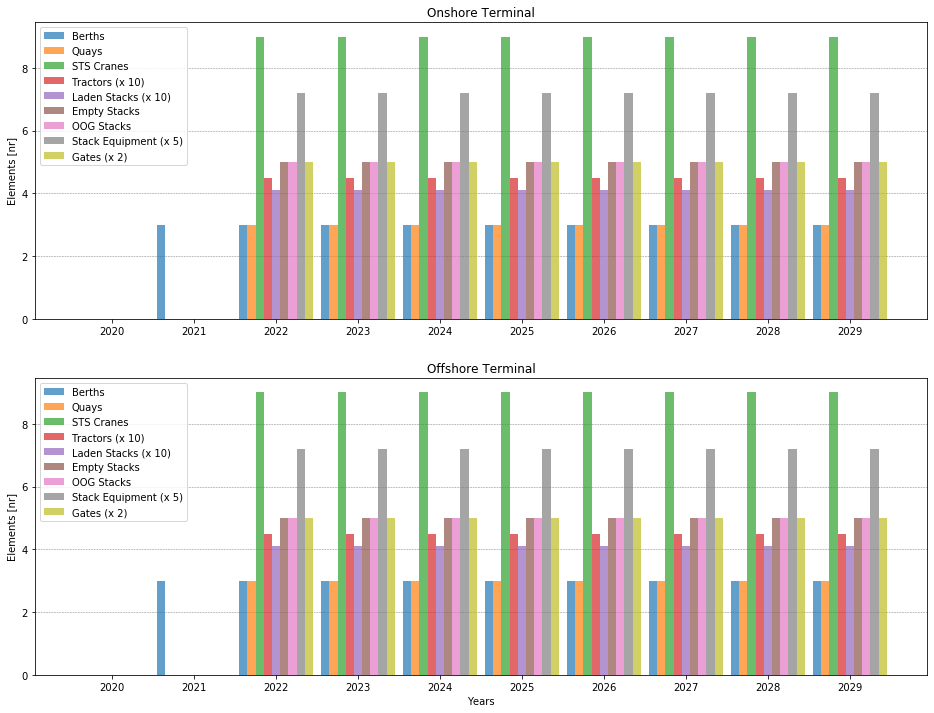

In [11]:
Terminal.terminal_elements_plot()

   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4129.0 h / 8640 oh
   > Total time at berth (planned) is 4129.0 h / 8640 oh
   > Total time at berth (online) is 4

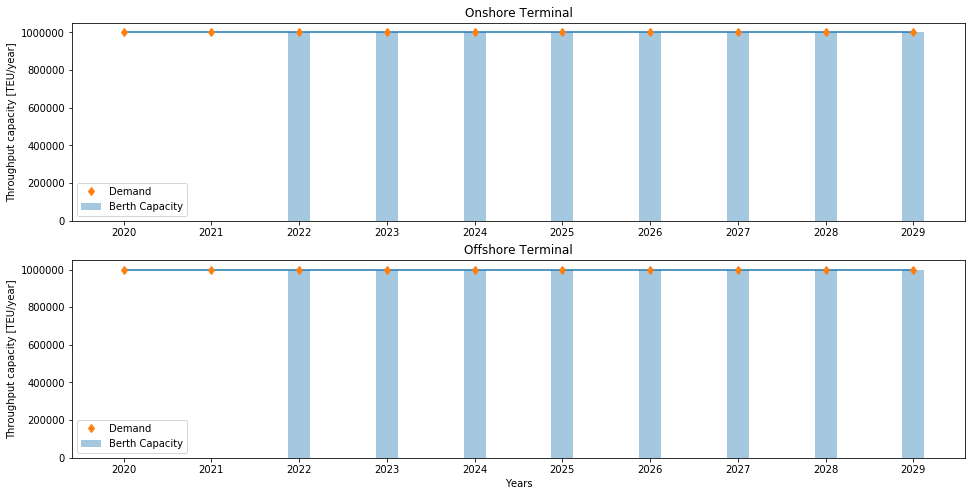

In [12]:
Terminal.terminal_capacity_plot()

   Year  Land use (ha)
0  2020       0.000000
1  2021       0.000000
2  2022      33.917695
3  2023      33.917695
4  2024      33.917695
5  2025      33.917695
6  2026      33.917695
7  2027      33.917695
8  2028      33.917695
9  2029      33.917695


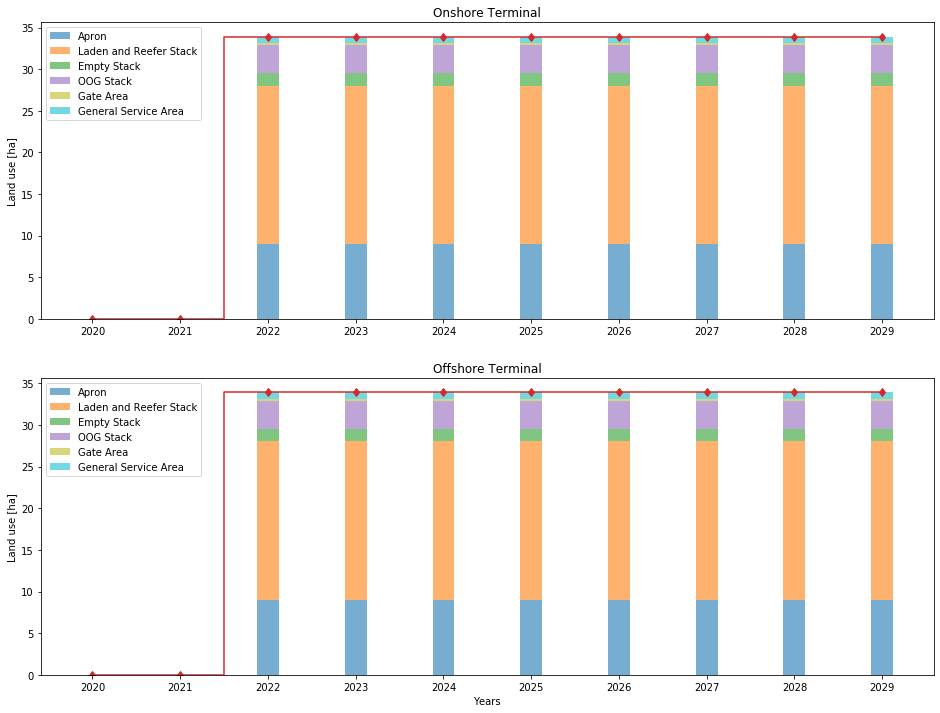

In [13]:
Terminal.terminal_land_use_plot()

   Year  Storage Area
0  2020          0.00
1  2021          0.00
2  2022         98.24
3  2023         98.24
4  2024         98.24
5  2025         98.24
6  2026         98.24
7  2027         98.24
8  2028         98.24
9  2029         98.24


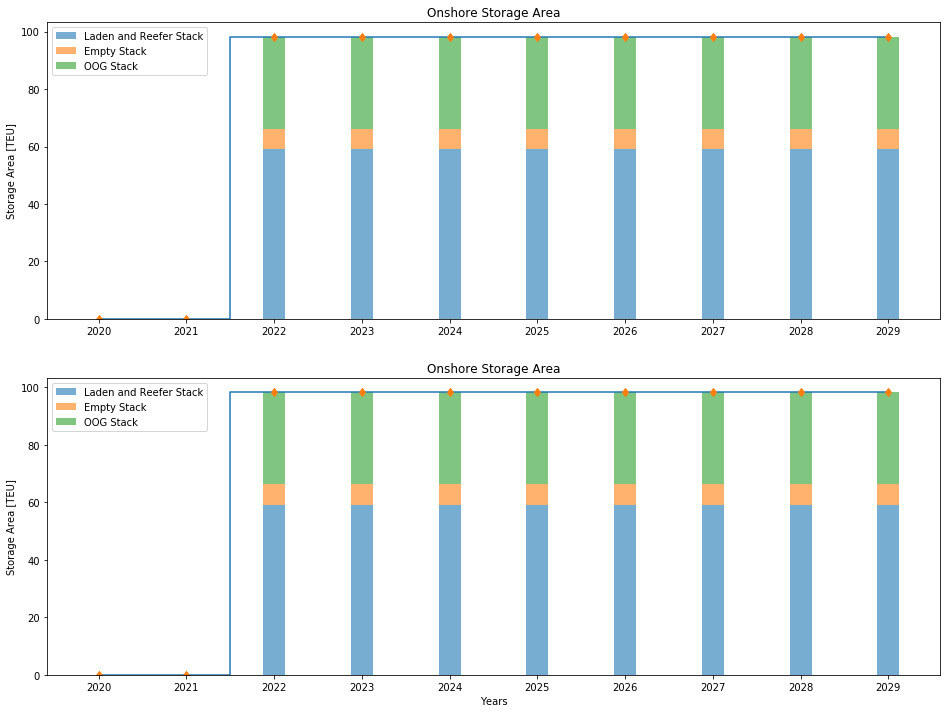

In [14]:
Terminal.storage_area_plot()

#### Add cash flow information for each of the terminal elements.

In [15]:
cash_flows, cash_flows_WACC_real = Terminal.add_cashflow_elements()

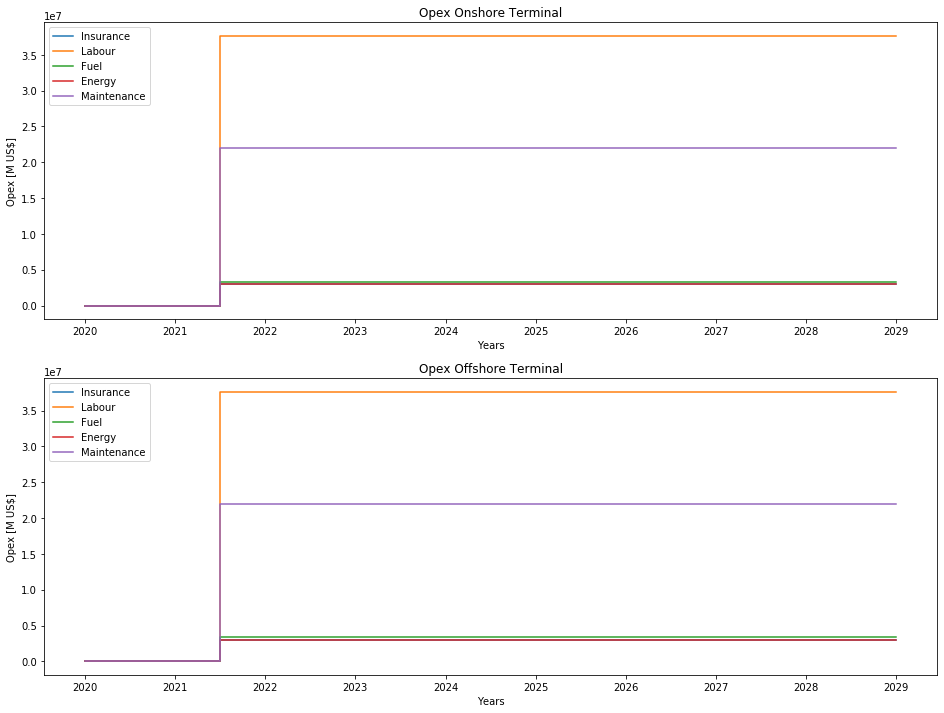

In [16]:
Terminal.terminal_opex_plot(cash_flows)

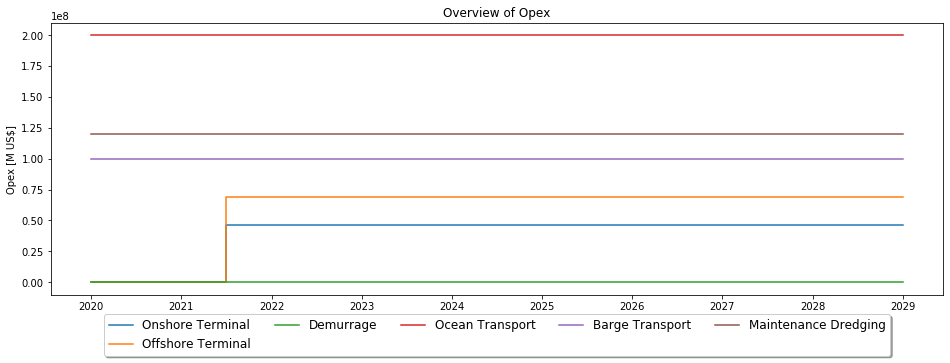

In [17]:
Terminal.total_opex_plot(cash_flows)

In [18]:
# print('\033[1mCash Flow Plot\033[0m')
# Terminal.cashflow_plot(cash_flows)

In [19]:
# scroll_to_current_cell(preserve=True)

Financial Indication

   Year         Capex  Capital Dredging   Maintenance     Insurance  \
0  2020  7.722579e+07      5.000000e+07  0.000000e+00  0.000000e+00   
1  2021  2.644186e+08      4.402624e+07  0.000000e+00  0.000000e+00   
2  2022  0.000000e+00      0.000000e+00  1.706716e+07  2.325948e+06   
3  2023  0.000000e+00      0.000000e+00  1.502806e+07  2.048055e+06   
4  2024  0.000000e+00      0.000000e+00  1.323258e+07  1.803363e+06   
5  2025  0.000000e+00      0.000000e+00  1.165161e+07  1.587906e+06   
6  2026  0.000000e+00      0.000000e+00  1.025953e+07  1.398191e+06   
7  2027  0.000000e+00      0.000000e+00  9.033775e+06  1.231142e+06   
8  2028  0.000000e+00      0.000000e+00  7.954464e+06  1.084051e+06   
9  2029  0.000000e+00      0.000000e+00  7.004103e+06  9.545338e+05   

         Energy        Labour          Fuel  Demurrage  Barge Transport  \
0  0.000000e+00  0.000000e+00  0.000000e+00        0.0              0.0   
1  0.000000e+00  0.000000e+00  0.000000e+00   

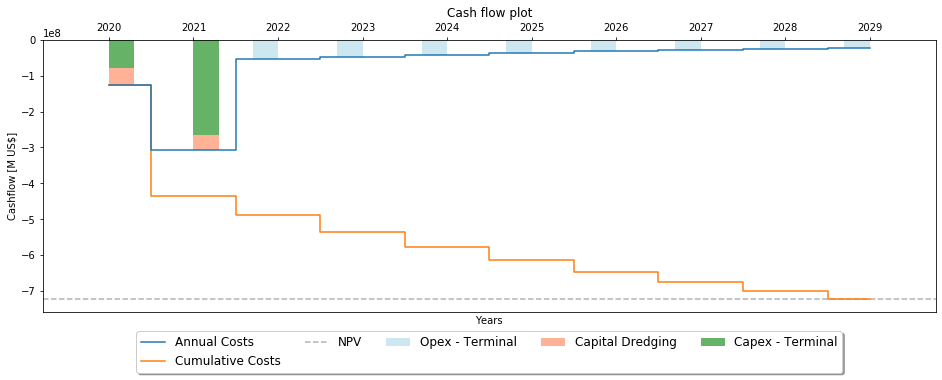

In [20]:
print('\033[1mFinancial Indication\033[0m')
print("")
Terminal.NPV()

print('')
print('\033[1mCash Flow Plot - Weighted average cost of capital\033[0m')
Terminal.cashflow_plot(cash_flows_WACC_real)